# CNN Tutorial with PyTorch on the MNIST Dataset

In this tutorial, we will build a Convolutional Neural Network (CNN) to classify handwritten digits from the MNIST dataset. We'll go through the following steps:

1. **Data Loading, Processing, and Augmentation**
2. **Data Exploration**
3. **Model Building**
4. **Model Training**
5. **Model Evaluation**



## 1. Data Loading, Processing, and Augmentation

The MNIST dataset consists of 28x28 pixel grayscale images of handwritten digits (0-9). We'll use PyTorch's `torchvision` to load and preprocess the data. We will also apply some augmentations to improve our model's robustness.

### Exercise

1. Import the necessary libraries.
2. Load the MNIST dataset using `torchvision.datasets`.
3. Apply normalization to the dataset.
4. Create data loaders for training and testing with appropriate batch sizes.
5. Experiment with different data augmentations like rotation, translation, and flipping.

In [22]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.0,), (1.0,)),
                                #transforms.Resize((28,28)),]
                                ])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=True)

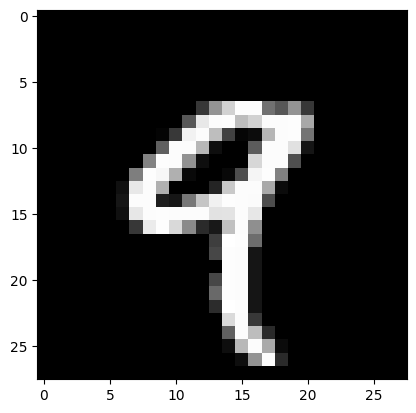

In [23]:
# plot image
import matplotlib.pyplot as plt

plt.imshow(train_dataset[4][0].numpy().squeeze(), cmap='gray')

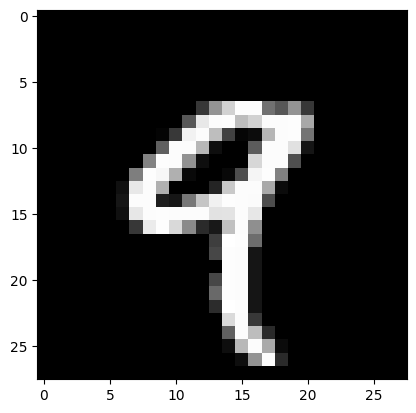

In [24]:
augmetation_transform = transforms.Compose([
    transforms.RandomRotation(degrees=15),
])

tranformed_example_image = augmetation_transform(train_dataset[4][0])

plt.imshow(tranformed_example_image.numpy().squeeze(), cmap='gray')

## 2. Data Exploration

Before training our model, it's essential to explore the data. This helps us understand its distribution and visualize some examples.

### Exercise
1. Visualize a few images from the training dataset along with their labels.
2. Print the number of samples in the training and test datasets.

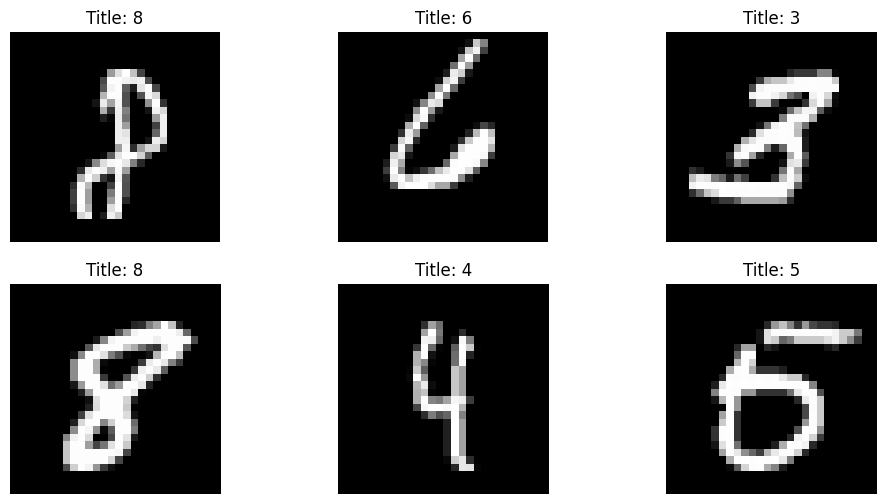

In [25]:

def show_images(images, labels):
    plt.figure(figsize=(12, 6))
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.title(f"Title: {labels[i]}")
        plt.axis(False)
    plt.show()
    
data = iter(train_loader)
images, labels = next(data)
show_images(images, labels)


## 3. Model Building

Now, we'll define our CNN architecture. A typical CNN consists of convolutional layers, activation functions, pooling layers, and a fully connected output layer.

### Exercise
1. Define a CNN class inheriting from torch.nn.Module.
2. Include two convolutional layers, ReLU activations, max pooling, and a fully connected layer.

In [26]:
from torch import nn

class CNNModel(nn.Module):
    
    def __init__(self, kernel_size, stride, padding):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=kernel_size, stride=stride, padding=padding)
        self.relu = nn.ReLU()
        self.avgpool = nn.AvgPool2d(kernel_size=kernel_size, stride=stride)
        self.fc = nn.Linear(11520, 110)
        self.dropout = nn.Dropout(0.5)
        self.batch_norm = nn.BatchNorm1d(110)
        self.fc2 = nn.Linear(110, 10)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        x = self.avgpool(self.relu(self.conv1(x)))
        x = self.conv2(x)
        x = self.relu(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.batch_norm(x)
        x = self.fc2(x)
        return self.softmax(x)

model = CNNModel(kernel_size=3, stride=1, padding=1)
print(model)

CNNModel(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (avgpool): AvgPool2d(kernel_size=3, stride=1, padding=0)
  (fc): Linear(in_features=11520, out_features=110, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (batch_norm): BatchNorm1d(110, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=110, out_features=10, bias=True)
  (softmax): LogSoftmax(dim=1)
)


## 4. Model Training

We'll now define the training loop to optimize our model using the cross-entropy loss function and the Adam optimizer.

### Exercise
1. Define a function to train the model for a specified number of epochs.
2. Print the training loss after each epoch.

In [27]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)

n_epochs = 10

for epoch in range(n_epochs):
    model.train()
    current_loss = 0
    correct = 0
    total = 0
    for image, label in train_loader:
        image = image.to(device)
        label = label.to(device)
        
        outputs = model(image)
        loss = criterion(outputs, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        current_loss += loss.item()

        _, preds = torch.max(outputs.data, 1)
        
        total += label.size(0)
        correct += (preds == label).sum()
        
    print(f"Loss: {current_loss / len(train_loader)}")
    print(f"Accuracy: {(correct / total) * 100:.2f}%")

Loss: 0.4839936563375789
Accuracy: 84.50%
Loss: 0.2115884193264917
Accuracy: 93.57%
Loss: 0.1692167459083582
Accuracy: 94.90%
Loss: 0.145013311883804
Accuracy: 95.54%
Loss: 0.12937622665385926
Accuracy: 96.05%
Loss: 0.11759269535630894
Accuracy: 96.42%
Loss: 0.11496999175913299
Accuracy: 96.54%
Loss: 0.10909468365727917
Accuracy: 96.71%
Loss: 0.10688522039825267
Accuracy: 96.69%
Loss: 0.0991101515159678
Accuracy: 97.00%


## 5. Model Evaluation

After training, we need to evaluate our model on the test dataset to understand its performance.

### Exercise
1. Define a function to evaluate the model's accuracy on the test set.
2. Print the accuracy.

In [28]:
model.eval()

total = 0
correct = 0
with torch.no_grad():
    for image, label in test_loader:
        image = image.to(device)
        label = label.to(device)
        outputs = model(image)
        _, preds = torch.max(outputs.data, 1)
        
        total += label.size(0)
        correct += (preds == label).sum()

print(f"Accuracy: {(correct / total) * 100:.2f}%")

Accuracy: 98.75%
